In [ ]:
# Needed if running on Colab
!pip3 install open-spiel
!pip3 install torch

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from go_search_problem import GoProblem, GoState
from heuristic_go_problems import GoProblemLearnedHeuristic, GoProblemSimpleHeuristic
from agents import GreedyAgent, RandomAgent, MCTSAgent, GameAgent, MinimaxAgent, AlphaBetaAgent, IterativeDeepeningAgent
import matplotlib.pyplot as plt
from tqdm import tqdm
from game_runner import run_many
import pickle
import pandas as pd
import matplotlib.pyplot as plt

torch.set_default_tensor_type(torch.FloatTensor)

/Users/lukelose/Desktop/cs1411/cs410_env/lib/python3.10/site-packages/torch/__init__.py:747: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:433.)
  _C._set_default_tensor_type(t)


In [4]:
def load_dataset(path: str):
    with open(path, 'rb') as f:
        dataset = pickle.load(f)
    return dataset

dataset_5x5 = load_dataset('dataset_5x5.pkl')
# dataset_9x9 = load_dataset('9x9_dataset.pkl')

In [5]:
def save_model(path: str, model):
    """
    Save model to a file
    Input:
        path: path to save model to
        model: Pytorch model to save
    """
    torch.save({
        'model_state_dict': model.state_dict(),
    }, path)

def load_model(path: str, model):
    """
    Load model from file

    Note: you still need to provide a model (with the same architecture as the saved model))

    Input:
        path: path to load model from
        model: Pytorch model to load
    Output:
        model: Pytorch model loaded from file
    """
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

# Task 1: Convert GameState to Features

In [6]:
def get_features(game_state: GoState):
    """
    Map a game state to a list of features.

    Some useful functions from game_state include:
        game_state.size: size of the board
        get_pieces_coordinates(player_index): get coordinates of all pieces of a player (0 or 1)
        get_pieces_array(player_index): get a 2D array of pieces of a player (0 or 1)

        get_board(): get a 2D array of the board with 4 channels (player 0, player 1, empty, and player to move). 4 channels means the array will be of size 4 x n x n

        Descriptions of these methods can be found in the GoState

    Input:
        game_state: GoState to encode into a fixed size list of features
    Output:
        features: list of features
    """
    board_size = game_state.size

    # TODO: Encode game_state into a list of features
    features = []
    #piece_coords_0 = game_state.get_pieces_coordinates(0)
    #pieces_array_0 = game_state.get_pieces_array(0)
    board = game_state.get_board()
    #print("coords now")
    #print(piece_coords_0)
    #print("array now")
    #print(pieces_array_0)
    black_board = board[0]
    white_board = board[1]
    player_to_go = board[3][0][0]
    

    black_positions_array = []
    white_positions_array = []
    
    #1-25 feature showing black pieces on the board
    for row in black_board:
        for possible_black_piece in row:
            if possible_black_piece == 1:
                black_positions_array.append(1)
            else:
                black_positions_array.append(0)

    #26-50 feature showing white pieces on the board
    for row in white_board:
        for possible_white_piece in row:
            if possible_white_piece == 1:
                white_positions_array.append(1)
            else:
                white_positions_array.append(0)

    #putting the individual arrays on the larger array
    features = black_positions_array + white_positions_array

    #51-57 feature showing player to move
    #nvm just 51
    if player_to_go == 0:
        features.append(0)
        # features.append(0)
        # features.append(0)
        # features.append(0)
        # features.append(0)
        # features.append(0)
        # features.append(0)
    else:
        features.append(1)
        # features.append(1)
        # features.append(1)
        # features.append(1)
        # features.append(1)
        # features.append(1)
        # features.append(1)

    #58-59 showing number of black and white pieces
    #just 52-53
    black_piece_amount = sum(1 for x in black_positions_array if x != 0)
    features.append(black_piece_amount)
    #print(black_piece_amount)
    white_piece_amount = sum(1 for x in white_positions_array if x != 0)
    features.append(white_piece_amount)
    #print(white_piece_amount)

    #60-65 showing number of possible moves for player to move
    #nevermind just 54
    player_to_go_possible_moves = len(game_state.legal_actions())
    features.append(player_to_go_possible_moves)
    # features.append(player_to_go_possible_moves)
    # features.append(player_to_go_possible_moves)
    # features.append(player_to_go_possible_moves)
    # features.append(player_to_go_possible_moves)
    # features.append(player_to_go_possible_moves)
    #print(player_to_go_possible_moves)

    
    # #print(black_board)
    # #print("black features")
    # #print(black_positions_array)
    # #print("white now")
    # #print(white_board)
    # #print("white array")
    # #print(white_positions_array)

    # #print(features)
    # features = []
    # board = game_state.get_board()  # This might return a Python list or a similar structure
    # np_board = np.array(board)   # Convert to a NumPy array
    # flat_np_board = np_board.flatten()
    # features.extend(flat_np_board)

    return features

data_point = dataset_5x5[100]
features = get_features(data_point[0])

In [7]:
# Print information about first data point
data_point = dataset_5x5[100]
features = get_features(data_point[0])
action = data_point[1]
result = data_point[2]
print(data_point[0])
print("features", features)
print("Action #", action)
print(len(features))
print("Game Result", result)

GoState(komi=0.5, to_play=W, history.size()=13)

 5 +X++O
 4 X+XX+
 3 +X+XO
 2 ++XOO
 1 +++++
   ABCDE

features [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 7, 4, 12]
Action # 2
54
Game Result 1.0


# Task 2: Supervised Learning of a Value Network

In [9]:
class ValueNetwork(nn.Module):
    def __init__(self, input_size):
      super(ValueNetwork, self).__init__()

      # TODO: What should the output size of a Value function be?
      output_size = 1

      # TODO: Add more layers, non-linear functions, etc.
      # self.linear = nn.Linear(input_size, 32)
      # self.linear_one = nn.Linear(32, 16)
      # self.linear_two = nn.Linear(16, 8)
      # self.linear_three = nn.Linear(8, output_size)

      # self.sigmoid = nn.Sigmoid()
      # self.tanh = nn.Tanh()
      # self.relu = nn.ReLU()

      self.linear = nn.Linear(input_size, 16)
      self.linear_one = nn.Linear(16, 24)
      self.linear_two = nn.Linear(24, 8)
      self.linear_three = nn.Linear(8, output_size)

      self.sigmoid = nn.Sigmoid()
      self.tanh = nn.Tanh()
      self.relu = nn.ReLU()

    def forward(self, x):
      """
      Run forward pass of network
      Input:
        x: input to network
      Output:
        output of network
      """
      # TODO: Update as more layers are added
      # layer_weight_one = self.linear(x)
      # activations_one = self.relu(layer_weight_one)
      # layer_weight_two = self.linear_one(activations_one)
      # activations_two = self.relu(layer_weight_two)
      # layer_weight_three = self.linear_two(activations_two)
      # activations_three = self.relu(layer_weight_three)
      # layer_weight_four = self.linear_three(activations_three)
      # return layer_weight_four
      layer_weight_one = self.linear(x)
      activations_one = self.tanh(layer_weight_one)
      layer_weight_two = self.linear_one(activations_one)
      layer_weight_three = self.linear_two(layer_weight_two)
      activations_three = self.tanh(layer_weight_three)
      layer_weight_four = self.linear_three(activations_three)
      return layer_weight_four

In [10]:
# This will not produce meaningful outputs until trained, but you can test for syntax errors
features_tensor = torch.Tensor(features)
value_net = ValueNetwork(len(features))
print("predicted Value", value_net(features_tensor))

predicted Value tensor([-0.1684], grad_fn=<ViewBackward0>)


train_acc: 73.16421895861149
test_acc: 74.88531153557427
Average epoch loss: 0.6945160316846792
train_acc: 76.11741160773849
test_acc: 75.37742931020102
Average epoch loss: 0.3288825825239516
train_acc: 75.10013351134846
test_acc: 75.78613729251813
Average epoch loss: 0.21574469103003918
train_acc: 77.1180787191461
test_acc: 76.47843856868796
Average epoch loss: 0.1582022788448187
train_acc: 78.17089452603471
test_acc: 77.13737592793393
Average epoch loss: 0.1233690582999789
train_acc: 79.11941294196131
test_acc: 77.62115272332973
Average epoch loss: 0.10039990636278048
train_acc: 79.70627503337784
test_acc: 77.8880640587205
Average epoch loss: 0.08438734256647223
train_acc: 79.0527018012008
test_acc: 78.27174910334473
Average epoch loss: 0.07242727463002369
train_acc: 79.5060080106809
test_acc: 78.7138210025857
Average epoch loss: 0.06319674859784032
train_acc: 78.1187458305537
test_acc: 79.00575527566936
Average epoch loss: 0.05606464706624271
train_acc: 79.63951935914552
test_acc: 7

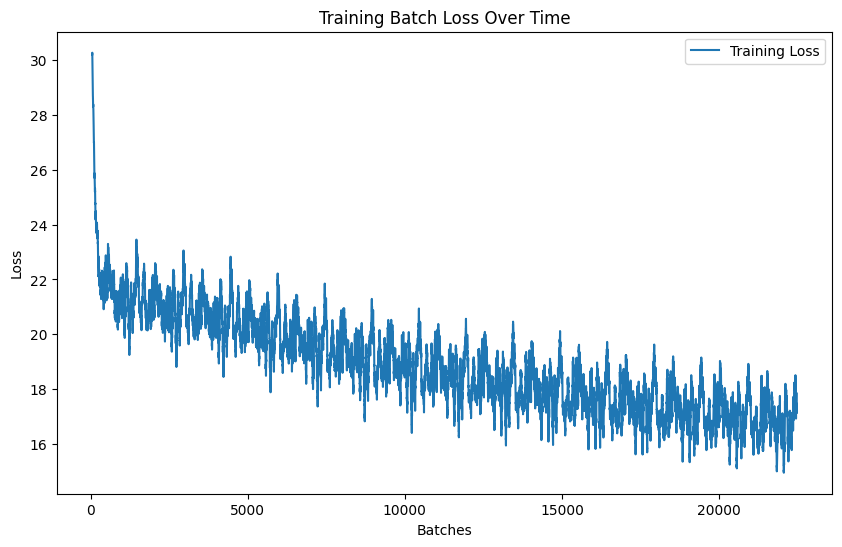

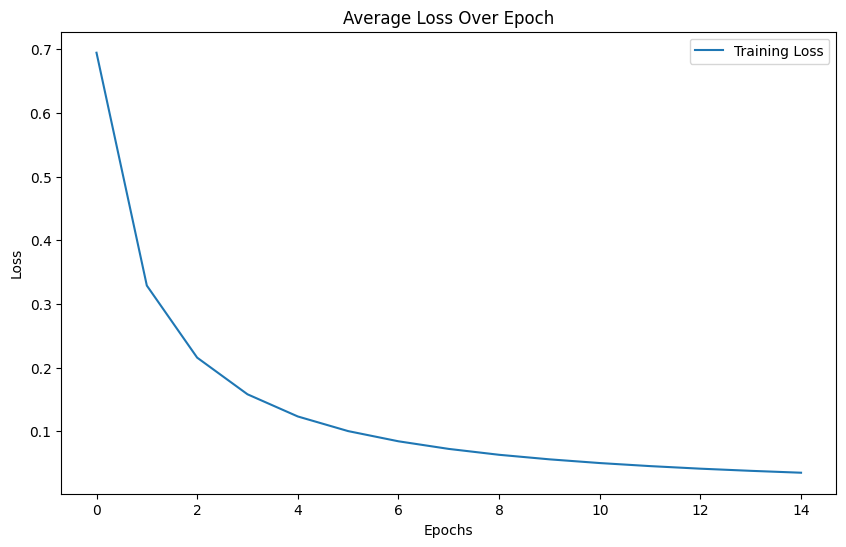

In [18]:
def train_value_network(dataset, num_epochs, learning_rate):
    """
    Train a value network on the provided dataset.

    Input:
        dataset: list of (state, action, result) tuples
        num_epochs: number of epochs to train for
        learning_rate: learning rate for gradient descent
    Output:
        model: trained model
    """
    # Make sure dataset is shuffled for better performance
    random.shuffle(dataset)
    #TRAIN TEST SPLIT
    split_index = int(0.8 * len(dataset))
    
    train_data = dataset[:split_index]
    test_data = dataset[split_index:]
    # You may find it useful to create train/test sets to better track performance/overfit/underfit
    # TODO: Create model
    #get input size
    feature_size = len(get_features(dataset[0][0]))
    model = ValueNetwork(feature_size)


    # TODO: Specify Loss Function
    loss_function = nn.MSELoss()

    # You can use Adam, which is stochastic gradient descent with ADAptive Momentum
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    batch_size = 32
    batch_loss = 0.0
    batch_counter = 0
    epoch_loss_list =[]
    batch_loss_list = []
    epoch_num = 0

    for epoch in range(num_epochs):

        total_train = 0
        total_test = 0
        correct_train = 0
        test_correct = 0
        epoch_loss = 0

        model.train()
        ranges = []
        for data_point in train_data:
            state = data_point[0]
            features = get_features(state)
            features_tensor = torch.tensor(features, dtype=torch.float32)

            # TODO: What should the desired output of the value network be?
            # Note: You will have to convert the label to a torch tensor to use with torch's loss functions
            label = data_point[2]
            label = torch.tensor(label, dtype=torch.float32).unsqueeze(0)
            #print(label)

            # TODO: Get model prediction of value
            prediction = model(features_tensor)
            ranges.append(prediction.item())
            #print(prediction)

            # TODO: Compute Loss for data point
            loss = loss_function(prediction, label)
            batch_loss += loss
            epoch_loss += loss.item()
            epoch_num += 1
            batch_counter += 1
            #epoch_num = 0
            if batch_counter % batch_size == 0:
                batch_loss_list.append(batch_loss.item())
                #epoch_num += 1
                # Call backward to run backward pass and compute gradients
                batch_loss.backward()

                # Run gradient descent step with optimizer
                optimizer.step()

                # Reset gradient for next batch
                optimizer.zero_grad()
                batch_loss = 0

                #Train model
                total_train += 1
                if prediction.item() >= 0:
                    predicted_value = 1
                else:
                    predicted_value = -1
                if predicted_value == label.item():
                    correct_train += 1

                train_acc = correct_train / total_train * 100
                #print("epoch " + str(epoch_num) + " train acc: " + str(train_acc))
        
        # min_bound = min(ranges)
        # max_bound = max(ranges)

        # print("min_bound: " + str(min_bound))
        # print("max_bound: " + str(max_bound))

        train_acc = correct_train / total_train * 100

        #test 
        model.eval()
        with torch.no_grad():
            for data_point in test_data:
                state = data_point[0]
                label = data_point[2]
                features = get_features(state)
                features_tensor = torch.tensor(features, dtype=torch.float32)

                # Forward pass
                prediction = model(features_tensor)

                #get the acc of the testing data
                #predicted_value = round(prediction.item())
                if prediction.item() >= 0:
                    predicted_value = 1
                else:
                    predicted_value = -1
                if predicted_value == label:
                    test_correct += 1
                total_test += 1

        test_acc = test_correct / total_test * 100
        avg_loss = epoch_loss / epoch_num
        epoch_loss_list.append(avg_loss)

        print("train_acc: " + str(train_acc))
        print("test_acc: " + str(test_acc))
        print("Average epoch loss: " + str(avg_loss))

    pd_smoothing = pd.Series(batch_loss_list)
    pd_smoothed = pd_smoothing.rolling(window=50).mean()
    plt.figure(figsize=(10,6))
    plt.plot(pd_smoothed, label='Training Loss')
    plt.xlabel('Batches')
    plt.ylabel('Loss')
    plt.title('Training Batch Loss Over Time')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(epoch_loss_list, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Average Loss Over Epoch')
    plt.legend()
    plt.show()

    return model

value_model = train_value_network(dataset_5x5, 15, 1e-3)
save_model("value_model.pt", value_model)

## Comparing Learned Value function against other Agents

In [12]:
class GoProblemLearnedHeuristic(GoProblem):
    def __init__(self, model=None, state=None):
        super().__init__(state=state)
        self.model = model
        
    def __call__(self, model=None):
        """
        Use the model to compute a heuristic value for a given state.
        """
        return self

    def encoding(self, state):
        """
        Get encoding of state (convert state to features)
        Note, this may call get_features() from Task 1. 

        Input:
            state: GoState to encode into a fixed size list of features
        Output:
            features: list of features
        """
        # TODO: get encoding of state (convert state to features)
        features = get_features(state)

        return features

    def heuristic(self, state, player_index):
        """
        Return heuristic (value) of current state

        Input:
            state: GoState to encode into a fixed size list of features
            player_index: index of player to evaluate heuristic for
        Output:
            value: heuristic (value) of current state
        """
        # TODO: Compute heuristic (value) of current state
        features = self.encoding(state)
        tensor_features = torch.tensor(features, dtype=torch.float32) 
        prediction_score = self.model(tensor_features)
        #prediction = torch.sigmoid(prediction_score)
        value = prediction_score.item()


        # Note, your agent may perform better if you force it not to pass
        # (i.e., don't select action #25 on a 5x5 board unless necessary)
        return value

    def __str__(self) -> str:
        return "Learned Heuristic"


def create_value_agent_from_model(model_string: str):
    """
    Create agent object from saved model. This (or other methods like this) will be how your agents will be created in gradescope and in the final tournament.
    """

    model_path = "value_model.pt"
    # TODO: Update number of features for your own encoding size
    #feature_size = 65
    feature_size = 54 #from the 54 features i have
    model = load_model(model_path, ValueNetwork(feature_size))
    heuristic_search_problem = GoProblemLearnedHeuristic(model)

    if model_string == "greedy":
        learned_agent = GreedyAgent(heuristic_search_problem)
    elif model_string == "mm2":
        learned_agent = MinimaxAgent(2, heuristic_search_problem)
    elif model_string == "ab3": 
        learned_agent = AlphaBetaAgent(3, heuristic_search_problem)
    elif model_string == "ab4": 
        learned_agent = AlphaBetaAgent(4, heuristic_search_problem)
    elif model_string == "ids":
        learned_agent = IterativeDeepeningAgent(5, heuristic_search_problem)
    else:
        raise NameError
    # TODO: Try with other heuristic agents (IDS/AB/Minimax)
    return learned_agent

def create_opponent(model_string: str):
    """
    creating opponent
    """
    model_path = "value_model.pt"
    feature_size = 54
    model = load_model(model_path, ValueNetwork(feature_size))
    heuristic_search_problem = GoProblemLearnedHeuristic(model)

    # TODO: Try with other heuristic agents (IDS/AB/Minimax)
    if model_string == "greedy":
        learned_agent = GreedyAgent(heuristic_search_problem)
    elif model_string == "mm2":
        learned_agent = MinimaxAgent(2, heuristic_search_problem)
    elif model_string == "ab3": 
        learned_agent = AlphaBetaAgent(3, heuristic_search_problem)
    elif model_string == "ab4": 
        learned_agent = AlphaBetaAgent(4, heuristic_search_problem)
    elif model_string == "ids":
        learned_agent = IterativeDeepeningAgent(5, heuristic_search_problem)
    else:
        raise NameError
    # TODO: Try with other heuristic agents (IDS/AB/Minimax)
    return learned_agent

learned_agent = create_value_agent_from_model("ab3")
opponent_agent = create_opponent("greedy")

run_many(learned_agent, MCTSAgent(), 4)

100%|██████████| 2/2 [02:29<00:00, 74.83s/it]

Agent 1: AlphaBeta w/ depth 3 + Learned Heuristic Score: 0.0
Agent 2: MCTS Score: 0.0
Agent 1: AlphaBeta w/ depth 3 + Learned Heuristic Score with Black (first move): 0.0
Agent 2: MCTS Score with Black (first move): 0.0
Agent 1: AlphaBeta w/ depth 3 + Learned Heuristic Average Duration: 0.03996129487167325
Agent 2: MCTS Average Duration: 1.5981245671709376
Agent 1: AlphaBeta w/ depth 3 + Learned Heuristic Longest Duration: 0.23575496673583984
Agent 2: MCTS Longest Duration: 14.504085063934326
Agent 1: AlphaBeta w/ depth 3 + Learned Heuristic Average Time Remaining: 37.33460313081741
Agent 2: MCTS Average Time Remaining: 1.5000106692314148
Agent 1: AlphaBeta w/ depth 3 + Learned Heuristic Min Time Remaining: 33.07225680351257
Agent 2: MCTS Min Time Remaining: 1.4999849796295166


(0.0, 0.0)

In [ ]:
#Code for the greedy comparisons
score_list = []
games_played_list = []
learned_agent = create_value_agent_from_model("greedy")
opponent_agent = create_opponent("greedy")
#Greedy learn vs greedy
games_played = 100
score = (run_many(learned_agent, GreedyAgent(), games_played))[0]
score_list.append(score)
games_played_list.append(games_played)
#Greedy learn vs minemax 2
games_played = 40
score = (run_many(learned_agent, MinimaxAgent(2), games_played))[0]
score_list.append(score)
games_played_list.append(games_played)
#Greedy learn vs ab 3
games_played = 40
score = (run_many(learned_agent, AlphaBetaAgent(3), games_played))[0]
score_list.append(score)
games_played_list.append(games_played)
#Greedy learn vs ab 4
games_played = 40
score = (run_many(learned_agent, AlphaBetaAgent(4), games_played))[0]
score_list.append(score)
games_played_list.append(games_played)
#Greedy learn vs ids
games_played = 4
score = (run_many(learned_agent, IterativeDeepeningAgent(3), games_played))[0]
score_list.append(score)
games_played_list.append(games_played)
#Greedy learn vs mcts
games_played = 4
score = (run_many(learned_agent, MCTSAgent(), games_played))[0]
score_list.append(score)
games_played_list.append(games_played)
#Greedy learn vs greedy learn
games_played = 100
score = (run_many(learned_agent, opponent_agent, games_played))[0]
score_list.append(score)
games_played_list.append(games_played)
print("scores")
print(score_list)
print("games played")
print(games_played_list)
win_rate_list = []
for i in range(len(score_list)):
    games_won = (score_list[i] + games_played_list[i]) / 2
    win_rate = games_won / games_played_list[i]
    win_rate_list.append(win_rate)

In [ ]:
print(score_list)
print(games_played_list)
print(win_rate_list)
xs = ["GRD L vs GRD", "GRD L vs MM2", "GRD L vs AB3", "GRD L vs AB4","GRD L vs IDS","GRD L vs MCTS","GRD L vs GRD L"]

plt.bar(xs, win_rate_list, alpha=0.9)
plt.xlabel("Actions")
plt.ylabel("Win Rate")
plt.title("Greedy Learn Win Rate by Model")
plt.ylim(0, 1.0)
plt.xticks(rotation=90)

Code for minemax learn

In [ ]:
#Code for the minemax comparisons
score_list = []
games_played_list = []
learned_agent = create_value_agent_from_model("mm2")
#mm2 learn vs mm2
games_played = 20
score = (run_many(learned_agent, MinimaxAgent(2), games_played))[0]
score_list.append(score)
games_played_list.append(games_played)
#mm2 learn vs ab3
games_played = 20
score = (run_many(learned_agent, AlphaBetaAgent(4), games_played))[0]
score_list.append(score)
games_played_list.append(games_played)

print("scores")
print(score_list)
print("games played")
print(games_played_list)
win_rate_list = []
for i in range(len(score_list)):
    games_won = (score_list[i] + games_played_list[i]) / 2
    win_rate = games_won / games_played_list[i]
    win_rate_list.append(win_rate)

In [ ]:
print(score_list)
print(games_played_list)
print(win_rate_list)
xs = ["MM2 L vs MM2", "MM2 L vs AB4"]

plt.figure(figsize=(4, 6))
plt.bar(xs, win_rate_list, alpha=0.9)
plt.xlabel("Actions")
plt.ylabel("Win Rate")
plt.title("Minemax Learn Win Rate by Model")
plt.ylim(0, 1.0)
plt.xticks(rotation=90)

Code for AB comparisons

In [ ]:
#Code for the ab comparisons
score_list = []
games_played_list = []
learned_agent = create_value_agent_from_model("ab3")
#ab3 learn vs ab3 
games_played = 20
score = (run_many(learned_agent, AlphaBetaAgent(3), games_played))[0]
score_list.append(score)
games_played_list.append(games_played)
#ab3 vs mcts
games_played = 6
score = (run_many(learned_agent, MCTSAgent(), games_played))[0]
score_list.append(score)
games_played_list.append(games_played)

print("scores")
print(score_list)
print("games played")
print(games_played_list)
win_rate_list = []
for i in range(len(score_list)):
    games_won = (score_list[i] + games_played_list[i]) / 2
    win_rate = games_won / games_played_list[i]
    win_rate_list.append(win_rate)

In [ ]:
print(score_list)
print(games_played_list)
print(win_rate_list)
xs = ["AB3 L vs AB3", "AB3 L vs MCTS"]

plt.figure(figsize=(4, 6))
plt.bar(xs, win_rate_list, alpha=0.9)
plt.xlabel("Actions")
plt.ylabel("Win Rate")
plt.title("Alpha Beta Learn Win Rate by Model")
plt.ylim(0, 1.0)
plt.xticks(rotation=90)

ids vs mcts

In [ ]:
#Code for the ab comparisons
score_list = []
games_played_list = []
learned_agent = create_value_agent_from_model("ids")
#ids learn vs mcts
games_played = 4
score = (run_many(learned_agent, MCTSAgent(), games_played))[0]
score_list.append(score)
games_played_list.append(games_played)

print("scores")
print(score_list)
print("games played")
print(games_played_list)
win_rate_list = []
for i in range(len(score_list)):
    games_won = (score_list[i] + games_played_list[i]) / 2
    win_rate = games_won / games_played_list[i]
    win_rate_list.append(win_rate)

In [ ]:
print(score_list)
print(games_played_list)
print(win_rate_list)
xs = ["IDS L vs MCTS"]

plt.figure(figsize=(4, 6))
plt.bar(xs, win_rate_list, alpha=0.9)
plt.xlabel("Actions")
plt.ylabel("Win Rate")
plt.title("IDS Learned inrate vs MCTS")
plt.ylim(0, 1.0)
plt.xticks(rotation=90)

# Task 3: Supervised Learning of a Policy Network

In [20]:
class PolicyNetwork(nn.Module):
    def __init__(self, input_size, board_size=5):
      super(PolicyNetwork, self).__init__()

      # TODO: What should the output size of the Policy be?
      output_size = 1 + board_size * board_size

      # TODO: Add more layers, non-linear functions, etc.

      self.linear = nn.Linear(input_size, 128)
      self.linear_one = nn.Linear(128, 64)
      self.linear_two = nn.Linear(64, 32)
      self.linear_three = nn.Linear(32, output_size)

      self.sigmoid = nn.Sigmoid()
      self.tanh = nn.Tanh()
      self.relu = nn.ReLU()

    def forward(self, x):
      layer_weight_one = self.linear(x)
      activations_one = self.relu(layer_weight_one)
      layer_weight_two = self.linear_one(activations_one)
      activations_two = self.relu(layer_weight_two)
      layer_weight_three = self.linear_two(activations_two)
      activations_three = self.relu(layer_weight_three)
      layer_weight_four = self.linear_three(activations_three)
      return layer_weight_four

In [21]:
# This will not produce meaningful outputs until trained, but you can test for syntax errors
features_tensor = torch.Tensor(features)
policy_net = PolicyNetwork(len(features))
print("Predicted Action Probabilities", policy_net(features_tensor))

Predicted Action Probabilities tensor([-0.1502,  0.0734, -0.1788,  0.2261, -0.0554,  0.1008, -0.0764, -0.1213,
         0.1280, -0.0188, -0.0128, -0.0655,  0.1533, -0.1567, -0.1766, -0.0894,
         0.0608,  0.2656, -0.0497, -0.1688, -0.0434,  0.0774,  0.1447, -0.1356,
         0.0039, -0.0960], grad_fn=<ViewBackward0>)


train_acc: 14.552736982643525
test_acc: 16.09808991575611
train_acc (best 5 moves): 35.51401869158878
test_acc (best 5 moves): 40.89582116940529
Average epoch loss: 3.0168977029488815
train_acc: 17.1447631754503
test_acc: 17.26582700809075
train_acc (best 5 moves): 42.69513008672448
test_acc (best 5 moves): 47.6686963049462
Average epoch loss: 2.887078227672503
train_acc: 17.022696929238982
test_acc: 18.033197097339226
train_acc (best 5 moves): 48.598130841121495
test_acc (best 5 moves): 50.204353991158555
Average epoch loss: 2.786849104850406
train_acc: 19.212808539026017
test_acc: 17.94978730502961
train_acc (best 5 moves): 51.70113408939293
test_acc (best 5 moves): 52.34798565351573
Average epoch loss: 2.72270853962258
train_acc: 16.15487316421896
test_acc: 18.00817415964634
train_acc (best 5 moves): 51.3351134846462
test_acc (best 5 moves): 53.89106681124364
Average epoch loss: 2.680519182021972
train_acc: 19.012675116744497
test_acc: 18.174993744265578
train_acc (best 5 moves): 53

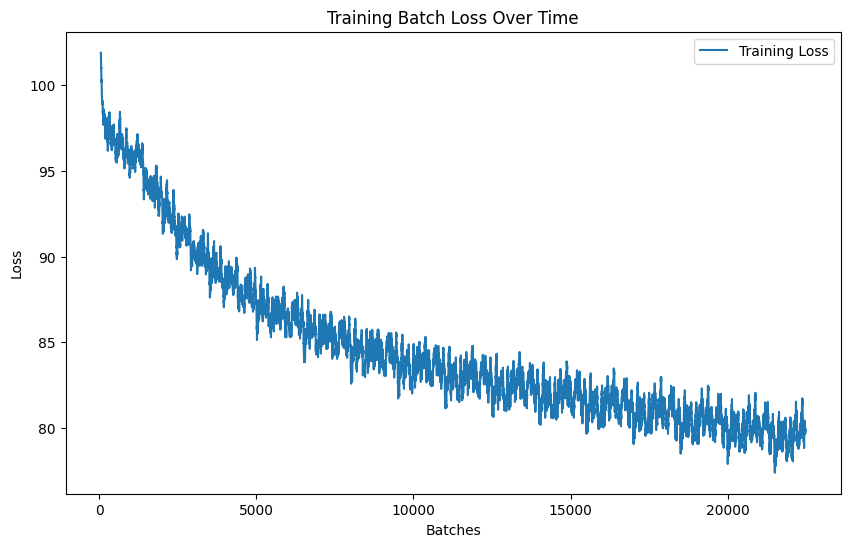

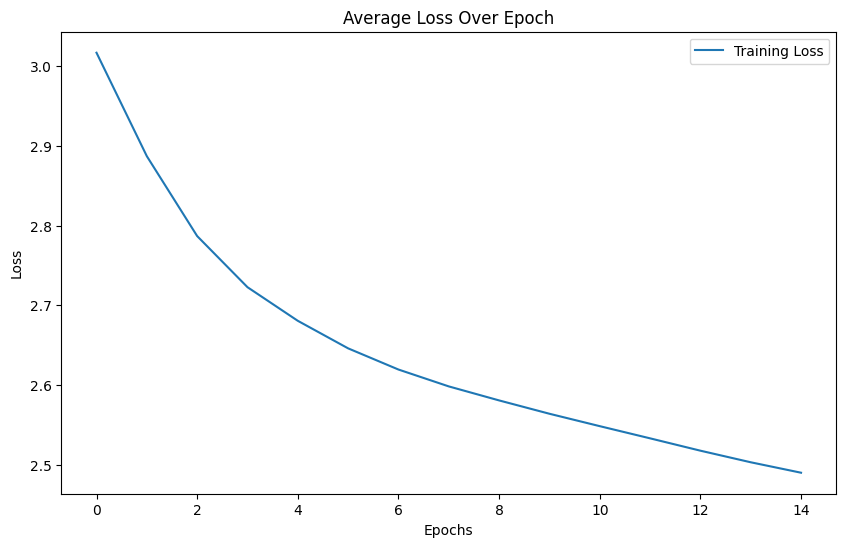

In [22]:
def train_policy_network(dataset, num_epochs, learning_rate):
    """
    Train a policy network on the provided dataset.

    Input:
        dataset: list of (state, action, result) tuples
        num_epochs: number of epochs to train for
        learning_rate: learning rate for gradient descent
    Output:
        model: trained model
    """
    random.shuffle(dataset)

    split_index = int(0.8 * len(dataset))
    train_data = dataset[:split_index]
    test_data = dataset[split_index:]

    batch_size = 32
    batch_loss = 0.0
    batch_counter = 0

    output_size = 26

    # TODO: Create model
    feature_size = len(get_features(dataset[0][0]))
    model = PolicyNetwork(feature_size)

    # TODO: Specify Loss Function
    loss_function =  nn.CrossEntropyLoss()

    # You can use Adam, which is stochastic gradient descent with ADAptive Momentum
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    check = []
    epoch_loss_list = []
    batch_loss_list = []
    # min_bound_og = (-100000)
    # max_bound_og = (100000)

    for epoch in range(num_epochs):

        total_train = 0
        total_test = 0
        correct_train = 0
        test_correct = 0
        correct_train_5 = 0
        correct_test_5 = 0
        epoch_num = 0
        epoch_loss = 0

        model.train()


        for data_point in train_data:
            optimizer.zero_grad()

            # TODO: Get features from state and convert features to torch tensor
            state = data_point[0]
            label = data_point[1]

            check.append(label)

            features = get_features(state)
            features_tensor = torch.tensor(features, dtype=torch.float32)

            # TODO: What should the desired output of the value network be?
            # Note: You will have to convert the label to a torch tensor to use with torch's loss functions
            label_tensor = torch.tensor(label, dtype=torch.long)

            # TODO: Get model estimate of value
            prediction = model(features_tensor)

            # TODO: Compute Loss for data point
            loss = loss_function(prediction.unsqueeze(0), label_tensor.unsqueeze(0))  # Add batch dimension
            batch_loss += loss
            epoch_loss += loss.item()
            epoch_num += 1
            #loss_list.append(loss.item())
            batch_counter += 1

            # Call backward to run backward pass and compute gradients
            # Run gradient descent step with optimizer
            if batch_counter % batch_size == 0:
                batch_loss_list.append(batch_loss.item())
                #print(batch_loss)
                # Backward pass and update
                batch_loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                batch_loss = 0

                # training acc
                total_train += 1
                best_5_moves = []
                best_action = torch.argmax(prediction).item()
                best_5_moves.append(best_action)
                prediction[best_action] = -100
                while len(best_5_moves) < 5:
                    predicted_action = torch.argmax(prediction).item()
                    best_5_moves.append(predicted_action)
                    prediction[predicted_action] = -100
                
                if best_action == label:
                    correct_train += 1

                if label in best_5_moves:
                    correct_train_5 += 1


        train_acc = correct_train / total_train * 100
        train_5_acc = correct_train_5 / total_train * 100

        #test 
        model.eval()
        with torch.no_grad():
            for data_point in test_data:
                state = data_point[0]
                label = data_point[1]
                features = get_features(state)
                features_tensor = torch.tensor(features, dtype=torch.float32)

                # Forward pass
                prediction = model(features_tensor)

                #get the acc of the testing data
                #predicted_value = round(prediction.item())
                # testing acc
                total_test += 1
                best_5_moves = []
                best_action = torch.argmax(prediction).item()
                best_5_moves.append(best_action)
                prediction[best_action] = -100
                while len(best_5_moves) < 5:
                    predicted_action = torch.argmax(prediction).item()
                    best_5_moves.append(predicted_action)
                    prediction[predicted_action] = -100
                
                if best_action == label:
                    test_correct += 1

                if label in best_5_moves:
                    correct_test_5 += 1
                    #print("does this ever get called")

        test_acc = test_correct / total_test * 100
        test_5_acc = correct_test_5 / total_test * 100
        avg_loss = epoch_loss / epoch_num
        epoch_loss_list.append(avg_loss)


        print("train_acc: " + str(train_acc))
        print("test_acc: " + str(test_acc))
        print("train_acc (best 5 moves): " + str(train_5_acc))
        print("test_acc (best 5 moves): " + str(test_5_acc))
        print("Average epoch loss: " + str(avg_loss))

    pd_smoothing = pd.Series(batch_loss_list)
    pd_smoothed = pd_smoothing.rolling(window=50).mean()
    plt.figure(figsize=(10,6))
    plt.plot(pd_smoothed, label='Training Loss')
    plt.xlabel('Batches')
    plt.ylabel('Loss')
    plt.title('Training Batch Loss Over Time')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(epoch_loss_list, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Average Loss Over Epoch')
    plt.legend()
    plt.show()

    return model

policy_net = train_policy_network(dataset_5x5, 15, 1e-3)
save_model("policy_model.pt", policy_net)

## Comparing Learned Policy against other Agents

In [78]:
class PolicyAgent(GameAgent):
    def __init__(self, search_problem, model_path, board_size=5):
        super().__init__()
        self.search_problem = search_problem
        #self.model = load_model(model_path, PolicyNetwork)
        #self.model = load_model(model_path, PolicyNetwork(54, 5))
        self.model = load_model(model_path, PolicyNetwork(65, 5))
        #self.model = load_model(model_path, "policy_model.pt")
        self.board_size = board_size

    def encoding(self, state):
        # TODO: get encoding of state (convert state to features)
        features = get_features(state)
        return features

    def get_move(self, game_state, time_limit=1):
      """
      Get best action for current state using self.model

      Input:
        game_state: current state of the game
        time_limit: time limit for search (This won't be used in this agent)
      Output:
        action: best action to take
      """

      # TODO: Select LEGAL Best Action predicted by model
      # The top prediction of your model may not be a legal move!

      features = self.encoding(game_state)
      tensor_features = torch.tensor(features, dtype=torch.float32) 
      action_probabilities = self.model(tensor_features)

      predicted_action = torch.argmax(action_probabilities).item()
      while predicted_action not in self.search_problem.get_available_actions(game_state):
          action_probabilities[predicted_action] -= 1
          predicted_action = torch.argmax(action_probabilities).item()


      # predicted_action = torch.argmin(action_probabilities).item()
      # worst_action = torch.max(action_probabilities).item()
      # action_probabilities[25] = worst_action + 1
      # while predicted_action not in self.search_problem.get_available_actions(game_state):
      #     action_probabilities[predicted_action] += 2
      #     predicted_action = torch.argmin(action_probabilities).item()
      
      assert predicted_action in self.search_problem.get_available_actions(game_state)
      return predicted_action

      # Note, you may want to force your policy not to pass their turn unless necessary

    def __str__(self) -> str:
        return "Policy Agent"
    
def create_policy_agent_from_model():
    """
    Create agent object from saved model. This (or other methods like this) will be how your agents will be created in gradescope and in the final tournament.    
    """
    model_path = "policy_model.pt"
    agent = PolicyAgent(GoProblem(size=5), model_path)
    return agent
    

In [ ]:
#policy_agent = PolicyAgent(GoProblem(size=5), PolicyNetwork(54))
policy_agent = create_policy_agent_from_model()
#policy_agent = PolicyAgent(GoProblem(size=5), "policy_model.pt")
print("Policy Agent", policy_agent)
run_many(policy_agent, GreedyAgent(), 100)

In [ ]:
#POLICY VS VALUE
score_list = []
games_played_list = []

value_agent_ab = create_value_agent_from_model("ab3")
policy_agent = create_policy_agent_from_model()
value_agent_greedy = create_value_agent_from_model("greedy")

#Greedy learned vs policy
games_played = 20
score = (run_many(value_agent_greedy, policy_agent, games_played))[0]
score_list.append(score)
games_played_list.append(games_played)

#AB learned vs policy
games_played = 20
score = (run_many(value_agent_ab, policy_agent, games_played))[0]
score_list.append(score)
games_played_list.append(games_played)

print("scores")
print(score_list)
print("games played")
print(games_played_list)
win_rate_list = []
for i in range(len(score_list)):
    games_won = (score_list[i] + games_played_list[i]) / 2
    win_rate = games_won / games_played_list[i]
    win_rate_list.append(win_rate)

print(score_list)
print(games_played_list)
print(win_rate_list)
xs = ["GRD L vs Policy", "AB L vs Policy"]

plt.figure(figsize=(4, 6))
plt.bar(xs, win_rate_list, alpha=0.9)
plt.xlabel("Actions")
plt.ylabel("Win Rate")
plt.title("IDS Learned inrate vs MCTS")
plt.ylim(0, 1.0)
plt.xticks(rotation=90)

In [ ]:
#Code for the greedy comparisons
score_list = []
games_played_list = []
#LEARNED AGENT IS POLICY
learned_agent = create_policy_agent_from_model()
opponent_agent = create_opponent("greedy")
#Greedy learn vs greedy
games_played = 100
score = (run_many(learned_agent, GreedyAgent(), games_played))[0]
score_list.append(score)
games_played_list.append(games_played)
#Greedy learn vs minemax 2
games_played = 40
score = (run_many(learned_agent, MinimaxAgent(2), games_played))[0]
score_list.append(score)
games_played_list.append(games_played)
#Greedy learn vs ab 3
games_played = 40
score = (run_many(learned_agent, AlphaBetaAgent(3), games_played))[0]
score_list.append(score)
games_played_list.append(games_played)
#Greedy learn vs ab 4
games_played = 40
score = (run_many(learned_agent, AlphaBetaAgent(4), games_played))[0]
score_list.append(score)
games_played_list.append(games_played)
#Greedy learn vs ids
games_played = 4
score = (run_many(learned_agent, IterativeDeepeningAgent(3), games_played))[0]
score_list.append(score)
games_played_list.append(games_played)
#Greedy learn vs mcts
games_played = 4
score = (run_many(learned_agent, MCTSAgent(), games_played))[0]
score_list.append(score)
games_played_list.append(games_played)
#Greedy learn vs greedy learn
games_played = 100
score = (run_many(learned_agent, opponent_agent, games_played))[0]
score_list.append(score)
games_played_list.append(games_played)
print("scores")
print(score_list)
print("games played")
print(games_played_list)
win_rate_list = []
for i in range(len(score_list)):
    games_won = (score_list[i] + games_played_list[i]) / 2
    win_rate = games_won / games_played_list[i]
    win_rate_list.append(win_rate)

In [ ]:
print(score_list)
print(games_played_list)
print(win_rate_list)
xs = ["Policy vs GRD", "Policy vs MM2", "Policy vs AB3", "Policy vs AB4", "Policy vs IDS", "Policy vs MCTS", "Policy vs GRD L"]

plt.figure(figsize=(10, 6))
plt.bar(xs, win_rate_list, alpha=0.9)
plt.xlabel("Actions")
plt.ylabel("Win Rate")
plt.title("IDS Learned inrate vs MCTS")
plt.ylim(0, 1.0)
plt.xticks(rotation=90)

# Submitting

After you've completed all the tasks in this notebook, you'll want to add your agents to your agents.py file. You'll want to copy the necessary function and class definitions for PolicyAgent, GoProblemLearnedHeuristic, PolicyNetwork, ValueNetwork, and any other methods you referenced. Your agents will ultimately be tested on gradescope by calling create_value_agent_from_model or by create_policy_agent_from_model.